<a href="https://colab.research.google.com/github/MiHess/cxr-bse/blob/master/data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import numpy as np
import PIL
import logging
import random
import matplotlib.pyplot as plt
plt.style.use('default')

from PIL import ImageOps
from skimage import exposure
from collections import defaultdict
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [0]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [0]:
bse_data_path = "/content/drive/My Drive/dev/bse/data"

jsrt_bse_path = os.path.join(bse_data_path, "jsrt_bse")

jsrt_path = os.path.join(bse_data_path, "jsrt")


In [0]:
def _load_grayscale_image(filepath):
    """
    """
    img_array = np.array(load_img(filepath))[:,:,1]
    
    return img_array.reshape((1,) + img_array.shape)  
    

def get_train_test_data(X_images_path, y_images_path, test_fraction=0.2):
    """ Loads all images from disk to memory and returns them as numpy array.
    """
    EXPECTED_TOTAL_NUMBER = 247
    
    X_image_filepaths = sorted(glob.glob(os.path.join(X_images_path, "*.png")))
    y_image_filepaths = sorted(glob.glob(os.path.join(y_images_path, "*.png")))
    
    if (len(X_image_filepaths) != EXPECTED_TOTAL_NUMBER) or (len(y_image_filepaths) != EXPECTED_TOTAL_NUMBER):
        raise ValueError(f"expected {EXPECTED_TOTAL_NUMBER} images. "
            f"Found {len(X_image_filepaths)} X and {len(y_image_filepaths)} y images, respectively.")
    else:
        logger.info(f"Found {len(X_image_filepaths)} X images and {len(y_image_filepaths)} y images.")    

    X_images = []
    y_images = []
    for X_image_filepath, y_image_filepath in zip(X_image_filepaths, y_image_filepaths):
        if os.path.basename(X_image_filepath) == os.path.basename(y_image_filepath):
            X_images.append(_load_grayscale_image(X_image_filepath))
            y_images.append(_load_grayscale_image(y_image_filepath))
        else:
            raise ValueError(f"image names do not match: {X_image_filepath} and {y_image_filepath}")
        
    test_idc = random.sample(range(EXPECTED_TOTAL_NUMBER), int(EXPECTED_TOTAL_NUMBER * test_fraction))
    train_idc = [idx for idx in range(EXPECTED_TOTAL_NUMBER) if idx not in test_idc]
    
    return np.array(X_images)[train_idc], np.array(y_images)[train_idc], \
        np.array(X_images)[test_idc], np.array(y_images)[test_idc]
        


In [0]:
X_train, y_train, X_test, y_test = get_train_test_data(jsrt_path, jsrt_bse_path)

In [7]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(49, 1, 512, 512)

In [89]:
seed = 1
batch_size=10


# basic_datagen = ImageDataGenerator(
#     rescale=1./255)

# baseline_X_generator = basic_datagen.flow(
#     X_train,
#     batch_size=batch_size,
#     seed=seed)

augmenting_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2, 
    vertical_flip=True)

train_X_generator = augmenting_datagen.flow(
    X_train, 
    batch_size=batch_size, 
    seed=seed)

train_y_generator = augmenting_datagen.flow(
    y_train, 
    batch_size=batch_size, 
    seed=seed)


train_generator = zip(train_X_generator, train_y_generator)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (198, 1, 512, 512) (512 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


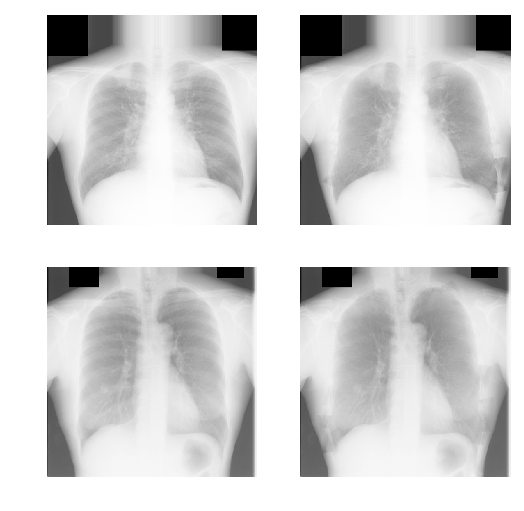

In [92]:
image, image_bse = next(train_generator)

examples = 2
fig, axes = plt.subplots(examples, 2, figsize=(6, 6), sharex=True, sharey=True)
for i in range(examples):
    axes[i, 0].imshow(image[i][0], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(image_bse[i][0], cmap='gray')
    axes[i, 1].axis('off')


In [0]:
model.fit_generator(
    train_datagen,
    steps_per_epoch=len(x_train) / 32, 
    epochs=epochs)